<a href="https://colab.research.google.com/github/MuaazZakria/MSDS19053_COVID19_DLSpring2020/blob/master/MSDS19053_A5_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment-5 
#Part-2

(MSDS 19053)

Some parts of my code have been taken from:
https://github.com/MSDS19026/MSDS19026_COVID19_DLSpring2020

# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount("./gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [3]:
!unzip "./gdrive/My Drive/Copy of A_05_Part_02_Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: A_05_Part_02_Dataset/Train/normal/52f18c9e-7262-4fcc-a6bc-78e707214886.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52f53bb5-81fb-408b-adc7-2f8ae8932b31.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52fee036-272a-455a-9714-b6ff73e28403.png  
  inflating: A_05_Part_02_Dataset/Train/normal/535c2337-e755-43ea-ab1d-6547a584776d.png  
  inflating: A_05_Part_02_Dataset/Train/normal/536ba3bf-b867-4035-b483-35e9cbda9c0f.png  
  inflating: A_05_Part_02_Dataset/Train/normal/538d24ba-8a55-4445-b0d5-f9e5812fdd49.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53bae9fc-3bb2-4684-b986-84bf7aa2e5a2.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53bed796-1a7b-406b-b37c-d37facb41158.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53c275e1-e692-4445-bb4f-b740d117712f.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53c369ae-d8f9-4e44-b212-c6e2dc6ef580.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53

In [0]:
!mkdir new_test

!mv "A_05_Part_02_Dataset/Test" "new_test"
!mv "new_test" "A_05_Part_02_Dataset"

# Normalizing our Dataset

In [5]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder('A_05_Part_02_Dataset/Train', transform=train_transforms)
valid_data = datasets.ImageFolder('A_05_Part_02_Dataset/Validation', transform=valid_transforms)
test_data = datasets.ImageFolder('A_05_Part_02_Dataset/new_test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers =4)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True,num_workers =4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True,num_workers =4)

print("Classes: ")
class_names = train_data.classes
#print(class_names)

order = [0, 2, 1]

class_names = [class_names[i] for i in order]

print(class_names)

Classes: 
['covid-19', 'pneumonia', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


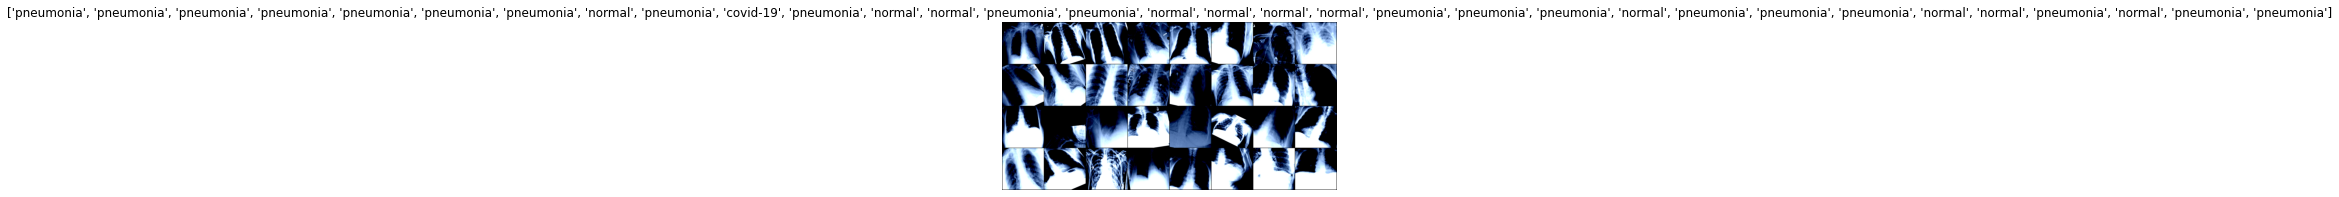

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

#**Task-1: VGG-16**

# Loading VGG

In [7]:
vgg16 = models.vgg16(pretrained=True)
#print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [8]:
num_features = vgg16.classifier[0].in_features
vggfeatures = list(vgg16.classifier.children())[:0] # Remove last layers

variable = (53*10)+100
vggfeatures.extend([nn.Linear(num_features, variable)])
vggfeatures.extend([nn.Linear(variable, len(class_names))])
vgg16.classifier = nn.Sequential(*vggfeatures)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Training for VGG-16

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
Sig = nn.Sigmoid()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
def o_h_v(label):

  o_h_vector = torch.zeros(len(label), 3)
  for i in range(len(label)):
    if label[i] == 0:                #Covid-19
      o_h_vector[i][0]=1
      o_h_vector[i][1]=1
    elif label[i] == 2:              #Pneumonia
      o_h_vector[i][1]=1
    else:
      o_h_vector[i][2]=1                 # Normal

  return o_h_vector

In [11]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
train_accuracy = []
train_loss = []
valid_accuracy = []
valid_loss = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    acc = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        targets = o_h_v(labels).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
  
        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, targets)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        
        sig_out = Sig(outputs.data)       # Sigmoid
        predicted=torch.round(sig_out)       #0.5 threshold
        
        for i in range(len(labels)):
          num=(predicted[i]*targets[i]).sum().item()
          den=(predicted[i].logical_or_(targets[i])).sum().item()
          acc+=num/den
        
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    train_accuracy.append(100 * acc / len(train_data))
    train_loss.append(running_loss)
    print('Accuracy: %d %%' % (train_accuracy[-1]))
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')


    acc = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(validloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        targets = o_h_v(labels).to(device)
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, targets)   #----> compute loss
        sig_out = Sig(outputs.data)       # Sigmoid
        predicted=torch.round(sig_out)       #0.5 threshold
        for i in range(len(labels)):
          num=(predicted[i]*targets[i]).sum().item()
          den=(predicted[i].logical_or_(targets[i])).sum().item()
          acc+=num/den
        running_loss += loss.item()
        # print statistics
        pbar.set_description(
            'Valid Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validloader.dataset),
                100. * i / len(validloader),
                loss.data))
    valid_accuracy.append(100 * acc / len(valid_data))
    valid_loss.append(running_loss)
    print('Accuracy: %d %%' % (valid_accuracy[-1]))
print('Finished Training')

Train Epoch: 0 [552/6200 (12%)]	Loss: 0.261526: : 194it [02:11,  1.48it/s]


Accuracy: 81 %


Valid Epoch: 0 [380/628 (95%)]	Loss: 0.030363: : 20it [00:09,  2.02it/s]

Accuracy: 89 %



Train Epoch: 1 [552/6200 (12%)]	Loss: 0.108825: : 194it [02:11,  1.48it/s]


Accuracy: 86 %


Valid Epoch: 1 [380/628 (95%)]	Loss: 0.119975: : 20it [00:10,  1.98it/s]

Accuracy: 89 %



Train Epoch: 2 [552/6200 (12%)]	Loss: 0.132382: : 194it [02:10,  1.48it/s]


Accuracy: 88 %


Valid Epoch: 2 [380/628 (95%)]	Loss: 0.128782: : 20it [00:10,  1.98it/s]

Accuracy: 91 %



Train Epoch: 3 [552/6200 (12%)]	Loss: 0.103313: : 194it [02:10,  1.48it/s]


Accuracy: 89 %


Valid Epoch: 3 [380/628 (95%)]	Loss: 0.303576: : 20it [00:10,  1.97it/s]

Accuracy: 92 %



Train Epoch: 4 [552/6200 (12%)]	Loss: 0.154153: : 194it [02:11,  1.47it/s]


Accuracy: 89 %


Valid Epoch: 4 [380/628 (95%)]	Loss: 0.149642: : 20it [00:10,  1.98it/s]

Accuracy: 92 %



Train Epoch: 5 [552/6200 (12%)]	Loss: 0.184853: : 194it [02:11,  1.47it/s]


Accuracy: 89 %


Valid Epoch: 5 [380/628 (95%)]	Loss: 0.064971: : 20it [00:10,  1.99it/s]

Accuracy: 92 %



Train Epoch: 6 [552/6200 (12%)]	Loss: 0.204357: : 194it [02:11,  1.47it/s]


Accuracy: 90 %


Valid Epoch: 6 [380/628 (95%)]	Loss: 0.022909: : 20it [00:10,  1.97it/s]

Accuracy: 92 %



Train Epoch: 7 [552/6200 (12%)]	Loss: 0.074279: : 194it [02:12,  1.47it/s]


Accuracy: 90 %


Valid Epoch: 7 [380/628 (95%)]	Loss: 0.249617: : 20it [00:10,  1.97it/s]

Accuracy: 92 %



Train Epoch: 8 [552/6200 (12%)]	Loss: 0.081475: : 194it [02:11,  1.47it/s]


Accuracy: 90 %


Valid Epoch: 8 [380/628 (95%)]	Loss: 0.030622: : 20it [00:10,  1.98it/s]

Accuracy: 94 %



Train Epoch: 9 [552/6200 (12%)]	Loss: 0.241442: : 194it [02:11,  1.48it/s]


Accuracy: 90 %


Valid Epoch: 9 [380/628 (95%)]	Loss: 0.249357: : 20it [00:10,  1.95it/s]

Accuracy: 92 %
Finished Training


# Confusion Matrices

**Training Confusion Matrices**

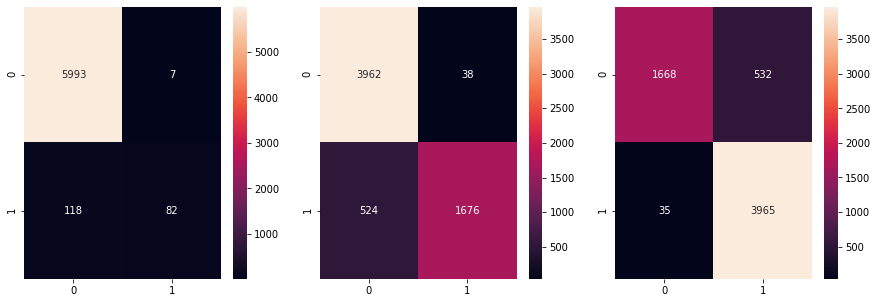

In [12]:
m = np.zeros((3,2,2))
with torch.no_grad():
  for data in trainloader:
    images, labels = data
    labels = o_h_v(labels)
    images, labels = images.to(device), labels.to(device)

    outputs = vgg16(images)
    sig_out = Sig(outputs.data)
    predicted=torch.round(sig_out)
    m += multilabel_confusion_matrix(labels.data.to('cpu'), predicted.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))

sns.heatmap(matrix0, annot=True, ax=ax1, fmt='g')

sns.heatmap(matrix1, annot=True, ax=ax2, fmt='g')

sns.heatmap(matrix2, annot=True, ax=ax3, fmt='g')

plt.show()

**Validation Confusion Matrices**

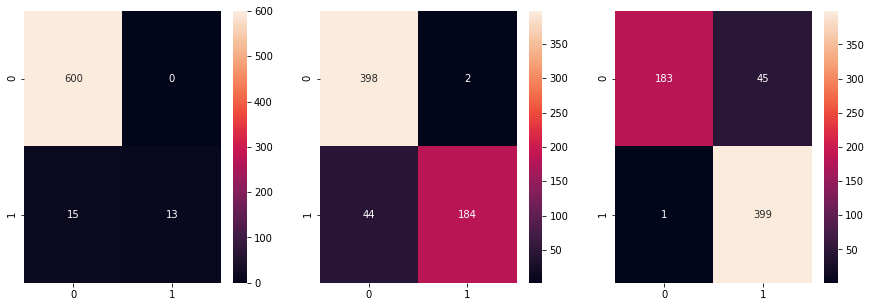

In [13]:
m = np.zeros((3,2,2))
with torch.no_grad():
  for data in validloader:
    images, labels = data
    labels = o_h_v(labels)
    images, labels = images.to(device), labels.to(device)

    outputs = vgg16(images)
    sig_out = Sig(outputs.data)
    predicted=torch.round(sig_out)
    m += multilabel_confusion_matrix(labels.data.to('cpu'), predicted.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))

sns.heatmap(matrix0, annot=True, ax=ax1, fmt='g')

sns.heatmap(matrix1, annot=True, ax=ax2, fmt='g')

sns.heatmap(matrix2, annot=True, ax=ax3, fmt='g')

plt.show()

**Testing Confusion Matrices**

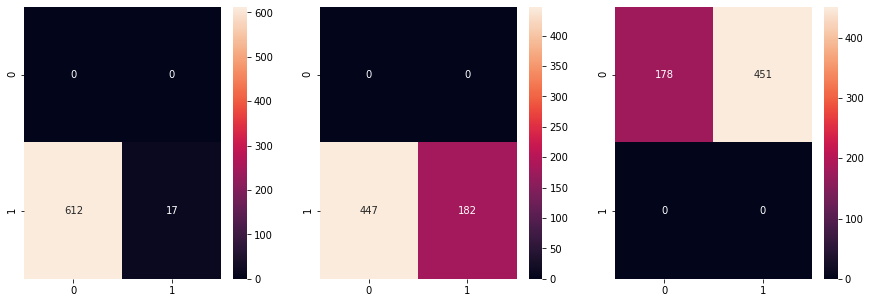

In [14]:
m = np.zeros((3,2,2))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    labels = o_h_v(labels)
    images, labels = images.to(device), labels.to(device)

    outputs = vgg16(images)
    sig_out = Sig(outputs.data)
    predicted=torch.round(sig_out)
    m += multilabel_confusion_matrix(labels.data.to('cpu'), predicted.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))

sns.heatmap(matrix0, annot=True, ax=ax1, fmt='g')

sns.heatmap(matrix1, annot=True, ax=ax2, fmt='g')

sns.heatmap(matrix2, annot=True, ax=ax3, fmt='g')

plt.show()

#Saving Testing Results in a CSV file

In [15]:
print("Testing Results\n\n\n")
    
prediction = torch.zeros(len(test_data), 3)
count=0
predicted_results=[]
image_name=[]
with torch.no_grad():
  for data,_ in testloader:
    images = data.to(device)
    outputs = vgg16(images)
    sig_out = Sig(outputs.data)       # Sigmoid
    predicted=torch.round(sig_out)       #0.5 threshold
    #print(predicted)
    for i in range(len(images)):
      sample_fname, _ = testloader.dataset.samples[i]                          #Finding path for current image
      spl_word = 'A_05_Part_02_Dataset/new_test/Test/'
      image_name.append(sample_fname.partition(spl_word)[-1])              #Taking out only name from the path
      prediction[count]=predicted[i]                        # Storing predicted results
      count+=1
      predicted_results.append(predicted[i].cpu().numpy().astype('int64'))
prediction.int()
  
  
results_array = np.array(predicted_results)

df = pd.DataFrame({'Image Name': image_name,'Covid-19': results_array[:, 0], 'Pneumonia': results_array[:, 1], 'Normal': results_array[:, 2]})

df.to_csv("/content/gdrive/My Drive/VGG16_results.csv")
print(df)

Testing Results



    Image Name  Covid-19  Pneumonia  Normal
0        0.png         0          0       1
1        1.png         0          0       1
2       10.png         0          1       0
3      100.png         0          0       1
4      101.png         0          1       0
..         ...       ...        ...     ...
624    112.png         0          0       1
625    113.png         0          0       1
626    114.png         0          1       0
627    115.png         0          0       1
628    116.png         0          1       0

[629 rows x 4 columns]


#**Task-1: ResNet-18**

#Loading ResNet

In [16]:
resnet18 = models.resnet18(pretrained= True)
#print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [17]:
#print(resnet18.fc)
no_features = resnet18.fc.in_features
resnetfeatures = list(resnet18.fc.children())[:0] # Remove last layers

variable = (53*10)+100
resnetfeatures.extend([nn.Linear(no_features, variable)])
resnetfeatures.extend([nn.Linear(variable, len(class_names))])
resnet18.fc = nn.Sequential(*resnetfeatures)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Training for ResNet-18

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
Sig = nn.Sigmoid()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [19]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
train_accuracy = []
train_loss = []
valid_accuracy = []
valid_loss = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    acc = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        targets = o_h_v(labels).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
  
        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, targets)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        
        sig_out = Sig(outputs.data)       # Sigmoid
        predicted=torch.round(sig_out)       #0.5 threshold
        
        for i in range(len(labels)):
          num=(predicted[i]*targets[i]).sum().item()
          den=(predicted[i].logical_or_(targets[i])).sum().item()
          acc+=num/den
        
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    train_accuracy.append(100 * acc / len(train_data))
    train_loss.append(running_loss)
    print('Accuracy: %d %%' % (train_accuracy[-1]))
    torch.save(resnet18.state_dict(), 'resnet18_ft.pth')


    acc = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(validloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        targets = o_h_v(labels).to(device)
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, targets)   #----> compute loss
        sig_out = Sig(outputs.data)       # Sigmoid
        predicted=torch.round(sig_out)       #0.5 threshold
        for i in range(len(labels)):
          num=(predicted[i]*targets[i]).sum().item()
          den=(predicted[i].logical_or_(targets[i])).sum().item()
          acc+=num/den
        running_loss += loss.item()
        # print statistics
        pbar.set_description(
            'Valid Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validloader.dataset),
                100. * i / len(validloader),
                loss.data))
    valid_accuracy.append(100 * acc / len(valid_data))
    valid_loss.append(running_loss)
    print('Accuracy: %d %%' % (valid_accuracy[-1]))
print('Finished Training')

Train Epoch: 0 [552/6200 (12%)]	Loss: 0.201341: : 194it [01:45,  1.84it/s]


Accuracy: 76 %


Valid Epoch: 0 [380/628 (95%)]	Loss: 0.226275: : 20it [00:08,  2.32it/s]

Accuracy: 85 %



Train Epoch: 1 [552/6200 (12%)]	Loss: 0.363539: : 194it [01:45,  1.85it/s]


Accuracy: 85 %


Valid Epoch: 1 [380/628 (95%)]	Loss: 0.251420: : 20it [00:08,  2.27it/s]

Accuracy: 88 %



Train Epoch: 2 [552/6200 (12%)]	Loss: 0.237907: : 194it [01:45,  1.83it/s]


Accuracy: 87 %


Valid Epoch: 2 [380/628 (95%)]	Loss: 0.279519: : 20it [00:08,  2.28it/s]

Accuracy: 90 %



Train Epoch: 3 [552/6200 (12%)]	Loss: 0.106796: : 194it [01:45,  1.84it/s]


Accuracy: 88 %


Valid Epoch: 3 [380/628 (95%)]	Loss: 0.092720: : 20it [00:08,  2.29it/s]

Accuracy: 90 %



Train Epoch: 4 [552/6200 (12%)]	Loss: 0.179841: : 194it [01:45,  1.84it/s]


Accuracy: 88 %


Valid Epoch: 4 [380/628 (95%)]	Loss: 0.141740: : 20it [00:08,  2.26it/s]

Accuracy: 91 %



Train Epoch: 5 [552/6200 (12%)]	Loss: 0.142430: : 194it [01:45,  1.85it/s]


Accuracy: 89 %


Valid Epoch: 5 [380/628 (95%)]	Loss: 0.272299: : 20it [00:08,  2.28it/s]

Accuracy: 91 %



Train Epoch: 6 [552/6200 (12%)]	Loss: 0.159781: : 194it [01:45,  1.84it/s]


Accuracy: 89 %


Valid Epoch: 6 [380/628 (95%)]	Loss: 0.223621: : 20it [00:08,  2.31it/s]

Accuracy: 90 %



Train Epoch: 7 [552/6200 (12%)]	Loss: 0.340319: : 194it [01:45,  1.83it/s]


Accuracy: 89 %


Valid Epoch: 7 [380/628 (95%)]	Loss: 0.312166: : 20it [00:08,  2.29it/s]

Accuracy: 91 %



Train Epoch: 8 [552/6200 (12%)]	Loss: 0.188273: : 194it [01:45,  1.84it/s]


Accuracy: 90 %


Valid Epoch: 8 [380/628 (95%)]	Loss: 0.076261: : 20it [00:08,  2.29it/s]

Accuracy: 91 %



Train Epoch: 9 [552/6200 (12%)]	Loss: 0.162911: : 194it [01:45,  1.84it/s]


Accuracy: 90 %


Valid Epoch: 9 [380/628 (95%)]	Loss: 0.173346: : 20it [00:08,  2.27it/s]

Accuracy: 92 %
Finished Training


# Confusion Matrices

**Training Confusion Matrices**

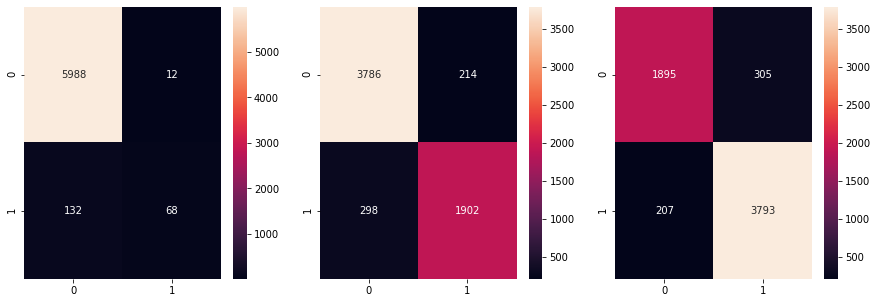

In [20]:
m = np.zeros((3,2,2))
with torch.no_grad():
  for data in trainloader:
    images, labels = data
    labels = o_h_v(labels)
    images, labels = images.to(device), labels.to(device)

    outputs = resnet18(images)
    sig_out = Sig(outputs.data)
    predicted=torch.round(sig_out)
    m += multilabel_confusion_matrix(labels.data.to('cpu'), predicted.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))

sns.heatmap(matrix0, annot=True, ax=ax1, fmt='g')


sns.heatmap(matrix1, annot=True, ax=ax2, fmt='g')


sns.heatmap(matrix2, annot=True, ax=ax3, fmt='g')

plt.show()

**Validation Confusion Matrices**

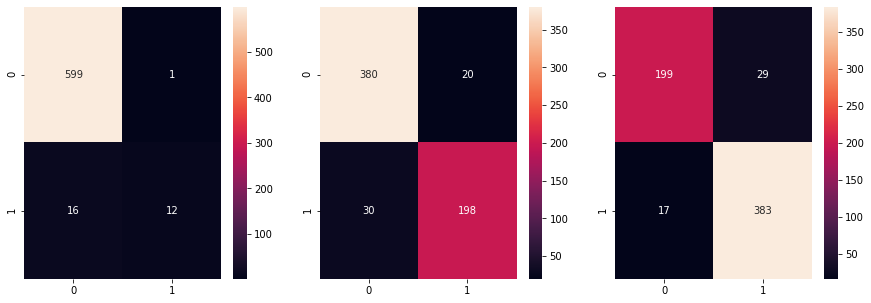

In [21]:
m = np.zeros((3,2,2))
with torch.no_grad():
  for data in validloader:
    images, labels = data
    labels = o_h_v(labels)
    images, labels = images.to(device), labels.to(device)

    outputs = resnet18(images)
    sig_out = Sig(outputs.data)
    predicted=torch.round(sig_out)
    m += multilabel_confusion_matrix(labels.data.to('cpu'), predicted.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))

sns.heatmap(matrix0, annot=True, ax=ax1, fmt='g')


sns.heatmap(matrix1, annot=True, ax=ax2, fmt='g')


sns.heatmap(matrix2, annot=True, ax=ax3, fmt='g')

plt.show()

**Testing Confusion Matrices**

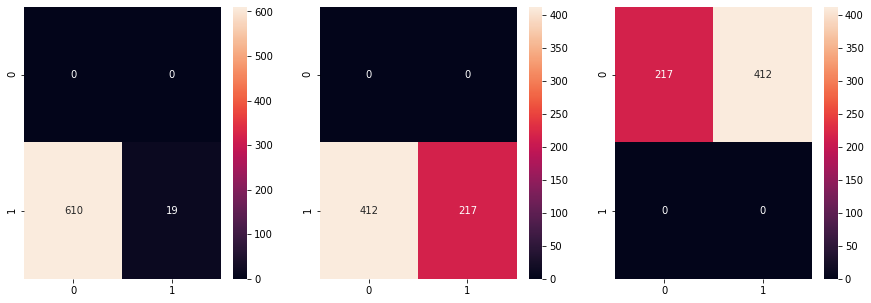

In [22]:
m = np.zeros((3,2,2))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    labels = o_h_v(labels)
    images, labels = images.to(device), labels.to(device)

    outputs = resnet18(images)
    sig_out = Sig(outputs.data)
    predicted=torch.round(sig_out)
    m += multilabel_confusion_matrix(labels.data.to('cpu'), predicted.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))

sns.heatmap(matrix0, annot=True, ax=ax1, fmt='g')


sns.heatmap(matrix1, annot=True, ax=ax2, fmt='g')


sns.heatmap(matrix2, annot=True, ax=ax3, fmt='g')

plt.show()

# Saving Testing Results in a CSV File

In [23]:
print("Testing Results\n\n\n")
    
prediction = torch.zeros(len(test_data), 3)
count=0
predicted_results=[]
image_name=[]
with torch.no_grad():
  for data,_ in testloader:
    images = data.to(device)
    outputs = resnet18(images)
    sig_out = Sig(outputs.data)       # Sigmoid
    predicted=torch.round(sig_out)       #0.5 threshold
    #print(predicted)
    for i in range(len(images)):
      sample_fname, _ = testloader.dataset.samples[i]                          #Finding path for current image
      spl_word = 'A_05_Part_02_Dataset/new_test/Test/'
      image_name.append(sample_fname.partition(spl_word)[-1])              #Taking out only name from the path
      prediction[count]=predicted[i]                        # Storing predicted results
      count+=1
      predicted_results.append(predicted[i].cpu().numpy().astype('int64'))
prediction.int()
  
  
results_array = np.array(predicted_results)

df = pd.DataFrame({'Image Name': image_name,'Covid-19': results_array[:, 0], 'Pneumonia': results_array[:, 1], 'Normal': results_array[:, 2]})

df.to_csv("/content/gdrive/My Drive/ResNet18_results.csv")
print(df)

Testing Results



    Image Name  Covid-19  Pneumonia  Normal
0        0.png         0          1       0
1        1.png         0          0       1
2       10.png         0          0       1
3      100.png         0          0       1
4      101.png         0          1       0
..         ...       ...        ...     ...
624    112.png         0          1       0
625    113.png         0          0       1
626    114.png         0          0       1
627    115.png         0          0       1
628    116.png         0          0       1

[629 rows x 4 columns]


#**Task-2: VGG16**

In [0]:
Epochs = 10
Sig = nn.Sigmoid()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
def focal_loss(pred, t_label, alpha, gamma):
  criterion = nn.BCEWithLogitsLoss(reduction= 'none')
  BCEWLL = criterion(pred, t_label)
  p_t = torch.exp(-BCEWLL)
  loss = alpha*((1 - p_t)**gamma)*BCEWLL
  return torch.mean(loss)

In [26]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
train_accuracy = []
train_loss = []
valid_accuracy = []
valid_loss = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    acc = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        targets = o_h_v(labels).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
  
        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass  
        loss = focal_loss(outputs, targets, 0.4, 2) #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        
        sig_out = Sig(outputs.data)       
        predicted=torch.round(sig_out)       
        
        for i in range(len(labels)):
          num=(predicted[i]*targets[i]).sum().item()
          den=(predicted[i].logical_or_(targets[i])).sum().item()
          acc+=num/den
        
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    train_accuracy.append(100 * acc / len(train_data))
    train_loss.append(running_loss)
    print('Accuracy: %d %%' % (train_accuracy[-1]))
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')


    acc = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(validloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        targets = o_h_v(labels).to(device)
        outputs = vgg16(inputs)               #----> forward pass
        loss = focal_loss(outputs, targets, 0.4, 2) #----> compute loss
        sig_out = Sig(outputs.data)       
        predicted=torch.round(sig_out)      
        for i in range(len(labels)):
          num=(predicted[i]*targets[i]).sum().item()
          den=(predicted[i].logical_or_(targets[i])).sum().item()
          acc+=num/den
        running_loss += loss.item()
        # print statistics
        pbar.set_description(
            'Valid Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validloader.dataset),
                100. * i / len(validloader),
                loss.data))
    valid_accuracy.append(100 * acc / len(valid_data))
    valid_loss.append(running_loss)
    print('Accuracy: %d %%' % (valid_accuracy[-1]))
print('Finished Training')

Train Epoch: 0 [552/6200 (12%)]	Loss: 0.015591: : 194it [02:11,  1.48it/s]


Accuracy: 91 %


Valid Epoch: 0 [380/628 (95%)]	Loss: 0.041205: : 20it [00:09,  2.04it/s]

Accuracy: 93 %



Train Epoch: 1 [552/6200 (12%)]	Loss: 0.007567: : 194it [02:11,  1.48it/s]


Accuracy: 91 %


Valid Epoch: 1 [380/628 (95%)]	Loss: 0.003887: : 20it [00:10,  2.00it/s]

Accuracy: 94 %



Train Epoch: 2 [552/6200 (12%)]	Loss: 0.008882: : 194it [02:11,  1.48it/s]


Accuracy: 91 %


Valid Epoch: 2 [380/628 (95%)]	Loss: 0.009910: : 20it [00:10,  1.93it/s]

Accuracy: 94 %



Train Epoch: 3 [552/6200 (12%)]	Loss: 0.009798: : 194it [02:11,  1.47it/s]


Accuracy: 91 %


Valid Epoch: 3 [380/628 (95%)]	Loss: 0.026699: : 20it [00:10,  1.98it/s]

Accuracy: 93 %



Train Epoch: 4 [552/6200 (12%)]	Loss: 0.016625: : 194it [02:10,  1.48it/s]


Accuracy: 91 %


Valid Epoch: 4 [380/628 (95%)]	Loss: 0.006265: : 20it [00:10,  1.98it/s]

Accuracy: 94 %



Train Epoch: 5 [552/6200 (12%)]	Loss: 0.017494: : 194it [02:12,  1.46it/s]


Accuracy: 92 %


Valid Epoch: 5 [380/628 (95%)]	Loss: 0.006495: : 20it [00:10,  2.00it/s]

Accuracy: 93 %



Train Epoch: 6 [552/6200 (12%)]	Loss: 0.011483: : 194it [02:12,  1.47it/s]


Accuracy: 92 %


Valid Epoch: 6 [380/628 (95%)]	Loss: 0.019362: : 20it [00:10,  2.00it/s]

Accuracy: 93 %



Train Epoch: 7 [552/6200 (12%)]	Loss: 0.025478: : 194it [02:12,  1.47it/s]


Accuracy: 92 %


Valid Epoch: 7 [380/628 (95%)]	Loss: 0.017985: : 20it [00:10,  1.96it/s]

Accuracy: 94 %



Train Epoch: 8 [552/6200 (12%)]	Loss: 0.013806: : 194it [02:12,  1.46it/s]


Accuracy: 91 %


Valid Epoch: 8 [380/628 (95%)]	Loss: 0.013394: : 20it [00:10,  2.00it/s]

Accuracy: 94 %



Train Epoch: 9 [552/6200 (12%)]	Loss: 0.034346: : 194it [02:11,  1.47it/s]


Accuracy: 92 %


Valid Epoch: 9 [380/628 (95%)]	Loss: 0.020953: : 20it [00:10,  1.99it/s]

Accuracy: 94 %
Finished Training


# Confusion Matrices

**Training Confusion Matrices**

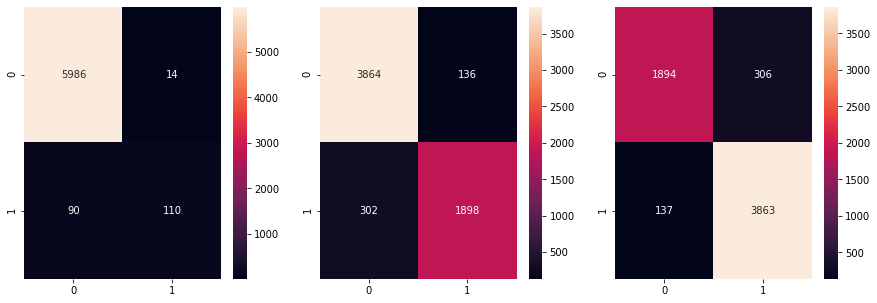

In [27]:
m = np.zeros((3,2,2))
with torch.no_grad():
  for data in trainloader:
    images, labels = data
    labels = o_h_v(labels)
    images, labels = images.to(device), labels.to(device)

    outputs = vgg16(images)
    sig_out = Sig(outputs.data)
    predicted=torch.round(sig_out)
    m += multilabel_confusion_matrix(labels.data.to('cpu'), predicted.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))

sns.heatmap(matrix0, annot=True, ax=ax1, fmt='g')

sns.heatmap(matrix1, annot=True, ax=ax2, fmt='g')

sns.heatmap(matrix2, annot=True, ax=ax3, fmt='g')

plt.show()

**Validation Confusion Matrices**

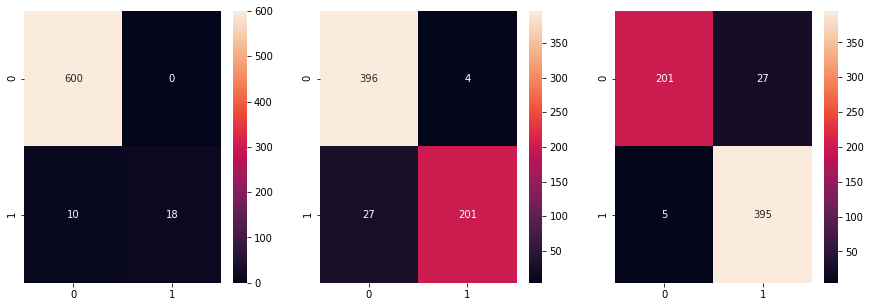

In [28]:
m = np.zeros((3,2,2))
with torch.no_grad():
  for data in validloader:
    images, labels = data
    labels = o_h_v(labels)
    images, labels = images.to(device), labels.to(device)

    outputs = vgg16(images)
    sig_out = Sig(outputs.data)
    predicted=torch.round(sig_out)
    m += multilabel_confusion_matrix(labels.data.to('cpu'), predicted.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))

sns.heatmap(matrix0, annot=True, ax=ax1, fmt='g')

sns.heatmap(matrix1, annot=True, ax=ax2, fmt='g')

sns.heatmap(matrix2, annot=True, ax=ax3, fmt='g')

plt.show()

**Testing Confusion Matrices**

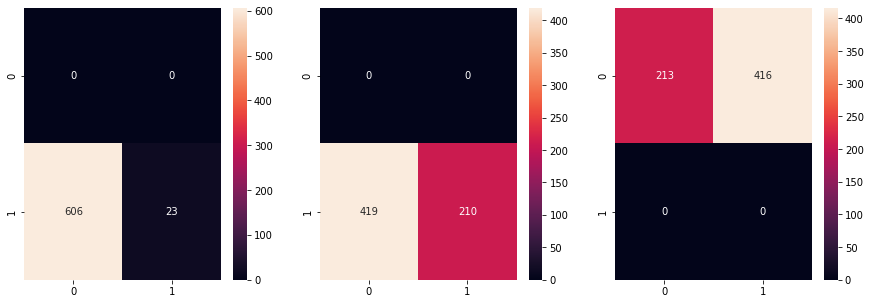

In [29]:
m = np.zeros((3,2,2))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    labels = o_h_v(labels)
    images, labels = images.to(device), labels.to(device)

    outputs = vgg16(images)
    sig_out = Sig(outputs.data)
    predicted=torch.round(sig_out)
    m += multilabel_confusion_matrix(labels.data.to('cpu'), predicted.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))

sns.heatmap(matrix0, annot=True, ax=ax1, fmt='g')

sns.heatmap(matrix1, annot=True, ax=ax2, fmt='g')

sns.heatmap(matrix2, annot=True, ax=ax3, fmt='g')

plt.show()

In [30]:
print("Testing Results\n\n\n")
    
prediction = torch.zeros(len(test_data), 3)
count=0
predicted_results=[]
image_name=[]
with torch.no_grad():
  for data,_ in testloader:
    images = data.to(device)
    outputs = vgg16(images)
    sig_out = Sig(outputs.data)       
    predicted=torch.round(sig_out)       
    #print(predicted)
    for i in range(len(images)):
      sample_fname, _ = testloader.dataset.samples[i]                          
      spl_word = 'A_05_Part_02_Dataset/new_test/Test/'
      image_name.append(sample_fname.partition(spl_word)[-1])              #Image Name
      prediction[count]=predicted[i]                        
      count+=1
      predicted_results.append(predicted[i].cpu().numpy().astype('int64'))
prediction.int()
  
  
results_array = np.array(predicted_results)

df = pd.DataFrame({'Image Name': image_name,'Covid-19': results_array[:, 0], 'Pneumonia': results_array[:, 1], 'Normal': results_array[:, 2]})

df.to_csv("/content/gdrive/My Drive/VGG16_Focal_results.csv")
print(df)

Testing Results



    Image Name  Covid-19  Pneumonia  Normal
0        0.png         1          1       0
1        1.png         0          0       1
2       10.png         0          0       1
3      100.png         0          0       1
4      101.png         0          0       1
..         ...       ...        ...     ...
624    112.png         0          0       1
625    113.png         0          0       1
626    114.png         0          1       0
627    115.png         0          0       1
628    116.png         0          0       1

[629 rows x 4 columns]


#**Task-2: ResNet-18**

In [31]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
train_accuracy = []
train_loss = []
valid_accuracy = []
valid_loss = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    acc = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        targets = o_h_v(labels).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
  
        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = focal_loss(outputs, targets, 0.4, 2) #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        
        sig_out = Sig(outputs.data)       
        predicted=torch.round(sig_out)       
        
        for i in range(len(labels)):
          num=(predicted[i]*targets[i]).sum().item()
          den=(predicted[i].logical_or_(targets[i])).sum().item()
          acc+=num/den
        
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    train_accuracy.append(100 * acc / len(train_data))
    train_loss.append(running_loss)
    print('Accuracy: %d %%' % (train_accuracy[-1]))
    torch.save(resnet18.state_dict(), 'resnet18_focal_ft.pth')


    acc = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(validloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        targets = o_h_v(labels).to(device)
        outputs = resnet18(inputs)               #----> forward pass
        loss = focal_loss(outputs, targets, 0.4, 2) #----> compute loss
        sig_out = Sig(outputs.data)       
        predicted=torch.round(sig_out)       
        for i in range(len(labels)):
          num=(predicted[i]*targets[i]).sum().item()
          den=(predicted[i].logical_or_(targets[i])).sum().item()
          acc+=num/den
        running_loss += loss.item()
        # print statistics
        pbar.set_description(
            'Valid Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validloader.dataset),
                100. * i / len(validloader),
                loss.data))
    valid_accuracy.append(100 * acc / len(valid_data))
    valid_loss.append(running_loss)
    print('Accuracy: %d %%' % (valid_accuracy[-1]))
print('Finished Training')

Train Epoch: 0 [552/6200 (12%)]	Loss: 0.013573: : 194it [01:46,  1.82it/s]


Accuracy: 90 %


Valid Epoch: 0 [380/628 (95%)]	Loss: 0.006564: : 20it [00:08,  2.28it/s]

Accuracy: 91 %



Train Epoch: 1 [552/6200 (12%)]	Loss: 0.126290: : 194it [01:46,  1.83it/s]


Accuracy: 90 %


Valid Epoch: 1 [380/628 (95%)]	Loss: 0.053030: : 20it [00:08,  2.25it/s]

Accuracy: 92 %



Train Epoch: 2 [552/6200 (12%)]	Loss: 0.018458: : 194it [01:45,  1.84it/s]


Accuracy: 90 %


Valid Epoch: 2 [380/628 (95%)]	Loss: 0.011196: : 20it [00:08,  2.29it/s]

Accuracy: 92 %



Train Epoch: 3 [552/6200 (12%)]	Loss: 0.065927: : 194it [01:45,  1.84it/s]


Accuracy: 90 %


Valid Epoch: 3 [380/628 (95%)]	Loss: 0.000676: : 20it [00:08,  2.25it/s]

Accuracy: 92 %



Train Epoch: 4 [552/6200 (12%)]	Loss: 0.029809: : 194it [01:46,  1.83it/s]


Accuracy: 90 %


Valid Epoch: 4 [380/628 (95%)]	Loss: 0.009145: : 20it [00:08,  2.29it/s]

Accuracy: 92 %



Train Epoch: 5 [552/6200 (12%)]	Loss: 0.007604: : 194it [01:46,  1.83it/s]

Accuracy: 90 %



Valid Epoch: 5 [380/628 (95%)]	Loss: 0.000341: : 20it [00:08,  2.27it/s]

Accuracy: 93 %



Train Epoch: 6 [552/6200 (12%)]	Loss: 0.013561: : 194it [01:45,  1.84it/s]

Accuracy: 90 %



Valid Epoch: 6 [380/628 (95%)]	Loss: 0.004895: : 20it [00:08,  2.23it/s]

Accuracy: 92 %



Train Epoch: 7 [552/6200 (12%)]	Loss: 0.008044: : 194it [01:45,  1.83it/s]


Accuracy: 90 %


Valid Epoch: 7 [380/628 (95%)]	Loss: 0.034916: : 20it [00:08,  2.29it/s]

Accuracy: 92 %



Train Epoch: 8 [552/6200 (12%)]	Loss: 0.009631: : 194it [01:45,  1.83it/s]


Accuracy: 90 %


Valid Epoch: 8 [380/628 (95%)]	Loss: 0.087851: : 20it [00:08,  2.24it/s]

Accuracy: 92 %



Train Epoch: 9 [552/6200 (12%)]	Loss: 0.022374: : 194it [01:45,  1.83it/s]

Accuracy: 90 %



Valid Epoch: 9 [380/628 (95%)]	Loss: 0.010737: : 20it [00:08,  2.26it/s]

Accuracy: 93 %
Finished Training


In [32]:
print("Testing Results\n\n\n")
    
prediction = torch.zeros(len(test_data), 3)
count=0
predicted_results=[]
image_name=[]
with torch.no_grad():
  for data,_ in testloader:
    images = data.to(device)
    outputs = resnet18(images)
    sig_out = Sig(outputs.data)       
    predicted=torch.round(sig_out)       
    #print(predicted)
    for i in range(len(images)):
      sample_fname, _ = testloader.dataset.samples[i]                          
      spl_word = 'A_05_Part_02_Dataset/new_test/Test/'
      image_name.append(sample_fname.partition(spl_word)[-1])              #Image Name
      prediction[count]=predicted[i]                        
      count+=1
      predicted_results.append(predicted[i].cpu().numpy().astype('int64'))
prediction.int()
  
  
results_array = np.array(predicted_results)

df = pd.DataFrame({'Image Name': image_name,'Covid-19': results_array[:, 0], 'Pneumonia': results_array[:, 1], 'Normal': results_array[:, 2]})

df.to_csv("/content/gdrive/My Drive/ResNet18_Focal_results.csv")
print(df)

Testing Results



    Image Name  Covid-19  Pneumonia  Normal
0        0.png         0          0       1
1        1.png         0          1       0
2       10.png         0          0       1
3      100.png         1          1       0
4      101.png         0          1       0
..         ...       ...        ...     ...
624    112.png         0          1       0
625    113.png         0          1       0
626    114.png         0          0       1
627    115.png         0          0       1
628    116.png         0          0       1

[629 rows x 4 columns]


#Confusion Matrices

**Training Confusion Matrices**

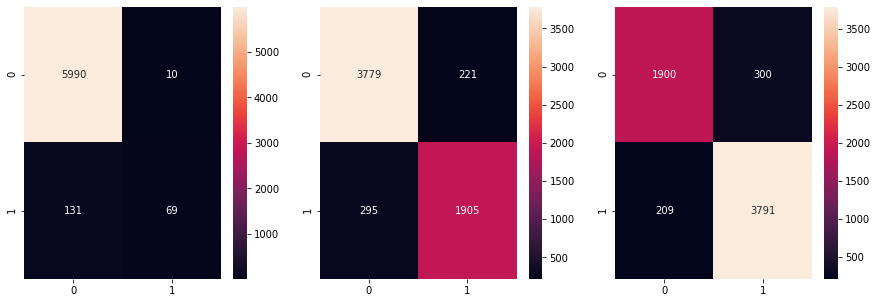

In [33]:
m = np.zeros((3,2,2))
with torch.no_grad():
  for data in trainloader:
    images, labels = data
    labels = o_h_v(labels)
    images, labels = images.to(device), labels.to(device)

    outputs = resnet18(images)
    sig_out = Sig(outputs.data)
    predicted=torch.round(sig_out)
    m += multilabel_confusion_matrix(labels.data.to('cpu'), predicted.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))

sns.heatmap(matrix0, annot=True, ax=ax1, fmt='g')

sns.heatmap(matrix1, annot=True, ax=ax2, fmt='g')

sns.heatmap(matrix2, annot=True, ax=ax3, fmt='g')

plt.show()

**Validation Confusion Matrices**

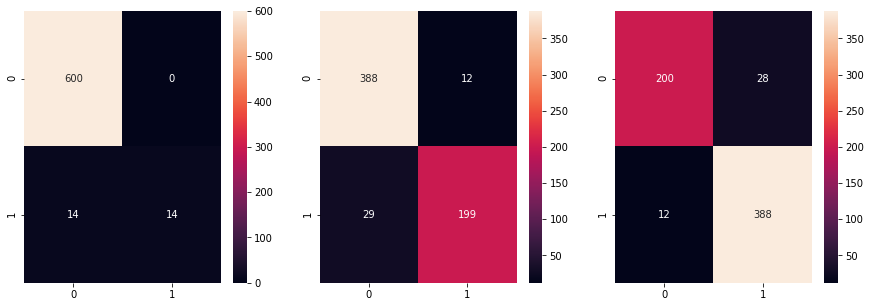

In [34]:
m = np.zeros((3,2,2))
with torch.no_grad():
  for data in validloader:
    images, labels = data
    labels = o_h_v(labels)
    images, labels = images.to(device), labels.to(device)

    outputs = resnet18(images)
    sig_out = Sig(outputs.data)
    predicted=torch.round(sig_out)
    m += multilabel_confusion_matrix(labels.data.to('cpu'), predicted.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))

sns.heatmap(matrix0, annot=True, ax=ax1, fmt='g')

sns.heatmap(matrix1, annot=True, ax=ax2, fmt='g')

sns.heatmap(matrix2, annot=True, ax=ax3, fmt='g')

plt.show()

**Testing Confusion Matrices**

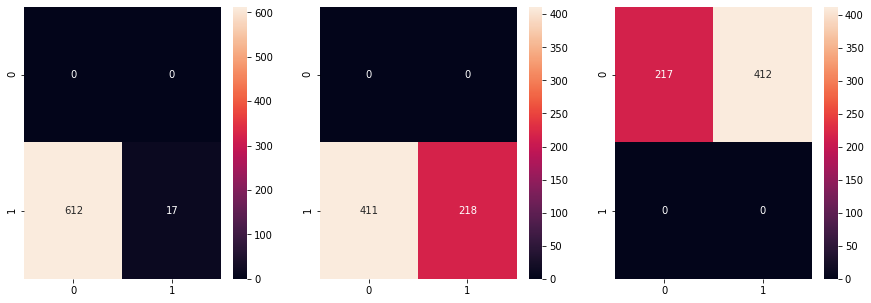

In [35]:
m = np.zeros((3,2,2))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    labels = o_h_v(labels)
    images, labels = images.to(device), labels.to(device)

    outputs = resnet18(images)
    sig_out = Sig(outputs.data)
    predicted=torch.round(sig_out)
    m += multilabel_confusion_matrix(labels.data.to('cpu'), predicted.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))

sns.heatmap(matrix0, annot=True, ax=ax1, fmt='g')

sns.heatmap(matrix1, annot=True, ax=ax2, fmt='g')

sns.heatmap(matrix2, annot=True, ax=ax3, fmt='g')

plt.show()